# Baseline model
This model contains the baseline model for the multiclass classification on the dataset.

### Preprocess

In [67]:
import pandas as pd
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import spacy
nlp = spacy.load("en_core_web_sm")
# Getting stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [68]:
# Read evidence
with open('../data/evidence.json', 'r') as f:
    evidence = json.load(f)

# Read train set
with open('../data/train-claims.json', 'r') as f:
    df = pd.DataFrame(json.load(f)).transpose()
df['ev_text'] = [[evidence[ev] for ev in line] for line in df['evidences']]

In [69]:
import re
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# NER and POS texts
def tag(text):
    doc = nlp(text)
    ner_tags = [entity.label_ for entity in doc.ents]
    pos_tags = [token.pos_ for token in doc]
    return ner_tags, pos_tags

# NER and POS texts
def NER(text):
    doc = nlp(text)
    ner_tags = [entity.label_ for entity in doc.ents]
    return ner_tags

def POS(text):
    doc = nlp(text)
    pos_tags = [token.pos_ for token in doc]
    return pos_tags

# Select columns to work on and retrieve tokenized and preprocesed vectors 
def feature_selection(feature, full=False):
    # Set words to lower and tokenize
    tokenized = [WordPunctTokenizer().tokenize(i.lower()) for i in feature]
    # Drop unknown characters (This may be modified depending model performance)
    tokenized = [' '.join([w for w in seq if re.match(r'^.*$', w)]) for seq in tokenized]
    # Stopwords
    tokenized = [' '.join([w for w in seq.split() if w not in stop_words]) for seq in tokenized]
    # Lemmatization
    tokenized = [' '.join([WordNetLemmatizer().lemmatize(w) for w in seq.split()]) for seq in tokenized]
    if full:
        # Extract NER and POS tags
        ner_tags = list(map(NER,feature))
        pos_tags = list(map(POS,feature))
        # Concatenate texts
        concatenated_texts = []
        for i in range(len(tokenized)):
            concatenated_texts.append(tokenized[i].split() + [' | '] + ner_tags[i] + [' | '] + pos_tags[i])
        return concatenated_texts
    return tokenized

In [70]:
evidences = []
for obs in range(df.shape[0]):
    sent = []
    for ev in range(len(df['ev_text'][obs])):
        sent.extend(feature_selection([df['ev_text'][obs][ev]], True)[0])
    evidences.append(' '.join(sent))

claims = [' '.join(feature_selection([df.loc[obs,'claim_text']], True)[0]) for obs in df.index]

### Vectorizer and dimensionality reduction

In [71]:
tvec = TfidfVectorizer(token_pattern=r'\b\w+\b')
ev = tvec.fit_transform(evidences).toarray()
cl = tvec.transform(claims).toarray()

In [72]:
df_ = pd.concat([pd.DataFrame(cl),pd.DataFrame(ev)], axis=1)

In [73]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2,random_state=42)
comp = pca.fit_transform(df_)

colors = df['claim_label'].apply(lambda x: 2 if x=='DISPUTED' else 
                                  1 if x=='REFUTES' else 
                                  0 if x== 'NOT_ENOUGH_INFO'
                                  else 3)

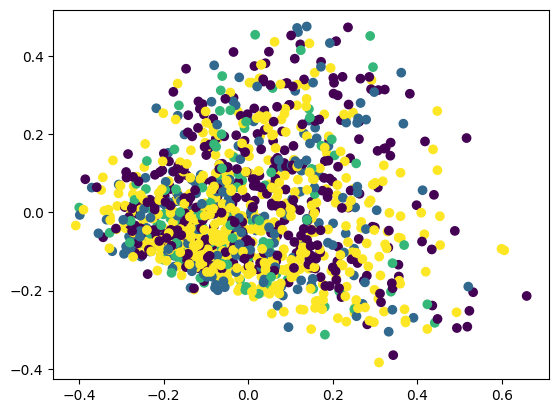

In [74]:
import matplotlib.pyplot as plt
plt.scatter(comp.T[0], comp.T[1], c=colors)

### Logistic regression model

In [75]:
df_train = pd.DataFrame(comp, columns=['comp_1', 'comp_2'])
df_train['label'] = colors.values

X = df_train.iloc[:,:-1]
y = df_train['label']

In [76]:
from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression(multi_class='multinomial', random_state=42).fit(X, y)

In [77]:
lreg.score(X, y)

0.43973941368078173

In [78]:
from sklearn.svm import SVC

svc = SVC(random_state=42, gamma=1000).fit(X, y)

In [79]:
svc.score(X, y)

0.5741042345276873

### Predict on dev dataset

*Prediction on dev dataset with evidences ranked based on best approach from previous step*

In [58]:
# Read dev set with evidences predicted on previous step
with open('../Models/Test files/dv-train-output.json', 'r') as f:
    df_dev = pd.DataFrame(json.load(f)).transpose()
df_dev['ev_text'] = [[evidence[ev] for ev in line] for line in df_dev['evidences']]

In [59]:
# Tokenize and preprocess dataset
evidences = []
for obs in range(df_dev.shape[0]):
    sent = []
    for ev in range(len(df_dev['ev_text'][obs])):
        sent.extend(feature_selection([df_dev['ev_text'][obs][ev]], True)[0])
    evidences.append(' '.join(sent))

claims = [' '.join(feature_selection([df_dev.loc[obs,'claim_text']], True)[0]) for obs in df_dev.index]

# TFIDF on inputed set
ev = tvec.transform(evidences).toarray()
cl = tvec.transform(claims).toarray()

# Final dataset to predict
df_dv = pd.concat([pd.DataFrame(cl),pd.DataFrame(ev)], axis=1)

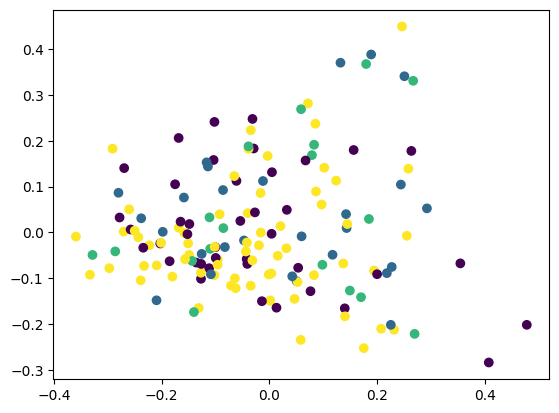

In [60]:
# Dimensionality reduction
comp = pca.transform(df_dv)

# Send labels to numbers
colors = df_dev['claim_label'].apply(lambda x: 2 if x=='DISPUTED' else 
                                  1 if x=='REFUTES' else 
                                  0 if x== 'NOT_ENOUGH_INFO'
                                  else 3)

# Plot components vs true labels
plt.scatter(comp.T[0], comp.T[1], c=colors)

In [62]:
# Dataframe to predict
df_dvs = pd.DataFrame(comp, columns=['comp_1', 'comp_2'])
df_dvs['label'] = colors.values

# Split predictors and regressors
X_dv = df_dvs.iloc[:,:-1]
y_dv = df_dvs['label']

# Predict on the model
print(lreg.score(X_dv, y_dv))
print(svc.score(X_dv, y_dv))

0.43506493506493504
0.42207792207792205
